Install the packages

In [163]:
!pip install numpy_financial
import numpy as np
import pandas as pd
from scipy.optimize import newton,fsolve,root,brentq
from datetime import datetime, timedelta
import numpy_financial as npf
import math
import matplotlib.pyplot as plt


Upload the dataset

In [164]:
df = pd.read_csv("data18561112.csv")

Yield to Maturity Curve

In [165]:
df['issue_date'] = pd.to_datetime(df['issue_date'])
df['maturity_date'] = pd.to_datetime(df['maturity_date'])

def calculate_ytm(price, coupon, maturity_date, current_date):
    current_date_str = f"{current_date} 2024"
    current_date_dt = datetime.strptime(current_date_str, "%b %d %Y")
    years_to_maturity = (maturity_date - current_date_dt).days / 365
    ytm = npf.rate(nper=years_to_maturity * 2, pmt=coupon / 2, pv=-price, fv=100) * 2
    return ytm

for date_column in df.columns[4:]:
    df[date_column + '_YTM'] = df.apply(lambda row: calculate_ytm(row[date_column], row['coupon'], row['maturity_date'], date_column), axis=1)

print(df)
ytm_columns = [col for col in df.columns if col.endswith('_YTM')]
df_ytm= df[ytm_columns].copy()

    coupon          ISIN issue_date maturity_date    Jan 8    Jan 9   Jan 10  \
0     0.25  CA135087L690 2020-10-16    2024-04-01   98.988   99.005   99.019   
1     1.50  CA135087J967 2019-04-05    2024-09-01   97.960   97.980   97.985   
2     1.25  CA135087K528 2019-10-11    2025-03-01   96.460   96.482   96.552   
3     0.50  CA135087K940 2020-04-03    2025-09-01   94.340   94.370   94.380   
4     0.25  CA135087L518 2020-10-09    2026-03-01   92.862   92.860   92.844   
5     1.00  CA135087L930 2021-04-16    2026-09-01   93.460   93.440   93.550   
6     1.25  CA135087M847 2021-10-15    2027-03-01   93.282   93.301   93.245   
7     2.75  CA135087N837 2022-05-13    2027-09-01   97.580   97.591   97.603   
8     3.50  CA135087P576 2022-10-21    2028-03-01  100.500  100.480  100.439   
9     3.25  CA135087Q491 2023-04-21    2028-09-01   99.740   99.720   99.720   
10    4.00  CA135087Q988 2023-10-13    2029-03-01  103.406  103.380  103.279   

     Jan 11   Jan 12   Jan 15  ...  Jan

In [166]:
ytm_columns = [col for col in df.columns if col.endswith('_YTM')]
df_ytm= df[ytm_columns].copy()

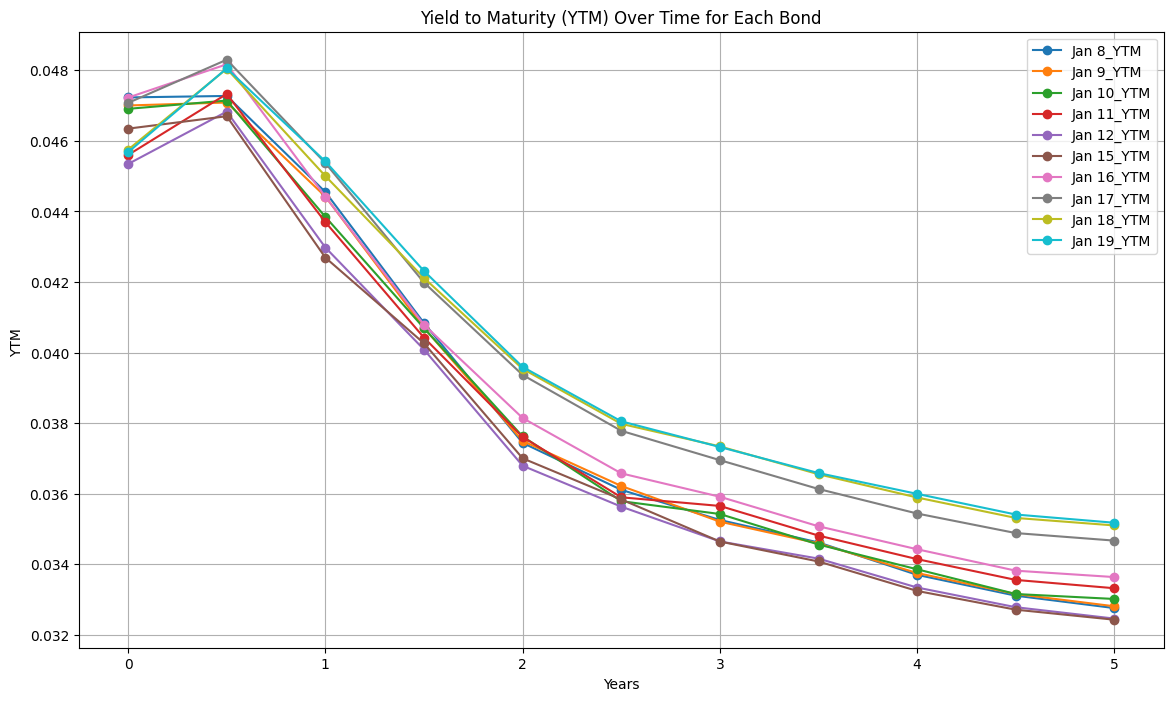

In [167]:
fig, ax = plt.subplots(figsize=(14, 8))
for bond in df_ytm.columns:
    ax.plot(df_ytm.index * 0.5, df_ytm[bond], marker='o', label=bond)
ax.set_title('Yield to Maturity (YTM) Over Time for Each Bond')
ax.set_xlabel('Years')
ax.set_ylabel('YTM ')
ax.set_xticks(np.arange(0, 6, 1))
ax.legend(loc='best')
ax.grid(True)
plt.show()


Spot Rate Curve

In [179]:
for date_column in df.columns[4:14]:
    # Precompute the string part for the datetime conversion
    current_date_str = f"{date_column} 2024"

    # Convert string to a datetime object once for the current column
    current_date_dt = datetime.strptime(current_date_str, "%b %d %Y")

    # Iterate over each row of the DataFrame by index
    for i in range(len(df)):
        # Access the entire row once
        row = df.iloc[i]

        # Calculate time to maturity
        time_to_maturity = (row['maturity_date'] - current_date_dt).days / 365

        # Select the appropriate action based on time to maturity
        if time_to_maturity < 0.3:
            df.at[i, f'{date_column}_spot'] = row[f'{date_column}_YTM']
        else:
            # Perform calculations for the spot rate
            coupon = row['coupon'] / 2
            p = 100 + coupon
            t = time_to_maturity
            P = row[date_column]

            # Initialize the summation term
            sum_term = 0
            for j in range(i-1):
                tj = t - 0.5 * (i - j)
                r_tj = df.at[j, f'{date_column}_spot']
                sum_term += coupon * math.exp(-r_tj * tj)

            # Calculate the spot rate and update the DataFrame
            df.at[i, f'{date_column}_spot'] = (np.log(p / (P - sum_term))) / t

spot_columns = [col for col in df.columns if col.endswith('_spot')]
df_spot = df[spot_columns].copy()

In [169]:
print(df_spot)

    Jan 8_spot  Jan 9_spot  Jan 10_spot  Jan 11_spot  Jan 12_spot  \
0     0.047230    0.047002     0.046907     0.045600     0.045343   
1     0.043250    0.043118     0.043222     0.043454     0.043017   
2     0.042550    0.042452     0.041914     0.041797     0.041118   
3     0.040007    0.039880     0.039882     0.039624     0.039302   
4     0.036938    0.036996     0.037125     0.037112     0.036315   
5     0.035276    0.035397     0.034981     0.035102     0.034853   
6     0.034437    0.034402     0.034631     0.034873     0.033887   
7     0.033349    0.033343     0.033340     0.033623     0.032993   
8     0.032345    0.032424     0.032563     0.032888     0.032105   
9     0.031920    0.031992     0.032016     0.032452     0.031696   
10    0.031537    0.031615     0.031863     0.032204     0.031354   

    Jan 15_spot  Jan 16_spot  Jan 17_spot  Jan 18_spot  Jan 19_spot  
0      0.046345     0.047226     0.047075     0.045750     0.045678  
1      0.043044     0.044533   

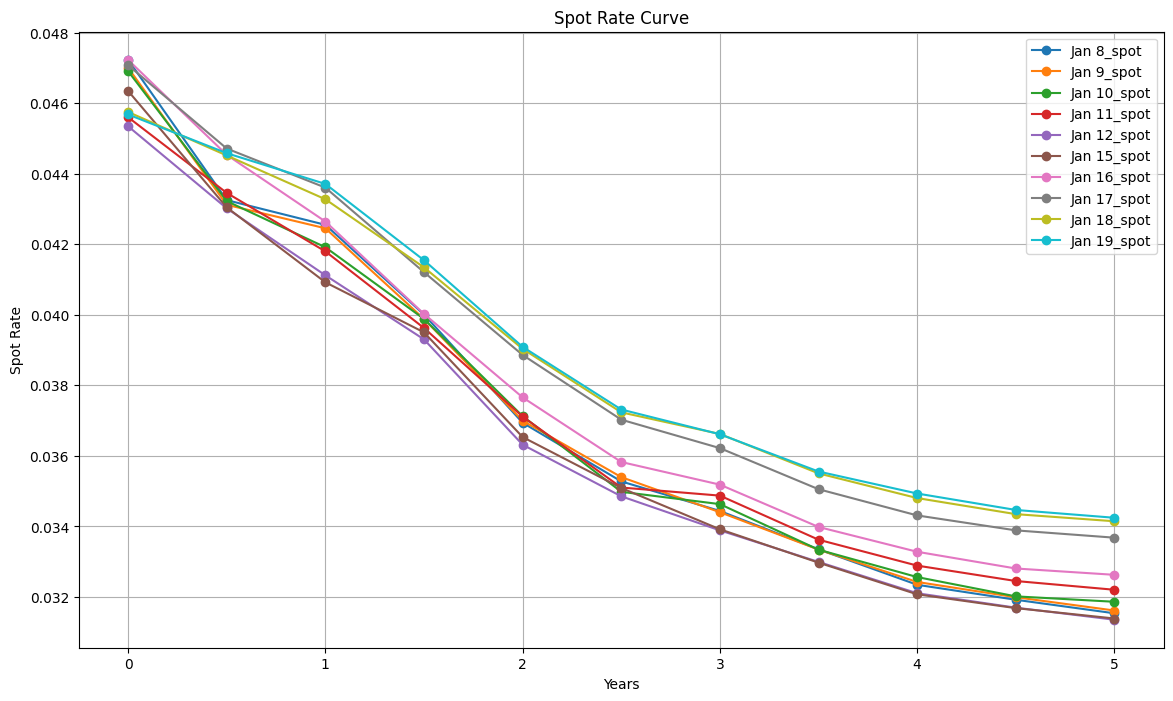

In [170]:
plt.figure(figsize=(14, 8))

for bond in df_spot.columns:
    plt.plot(df_spot.index * 0.5, df_spot[bond], marker='o', label=bond)

plt.title('Spot Rate Curve')
plt.xlabel('Years')
plt.ylabel('Spot Rate')
plt.xticks(np.arange(0, 6, 1))
plt.legend(loc='best')
plt.grid(True)
plt.show()

Forward Rate Curve

In [180]:
def calculate_forward_rate(r_0, t, r_01):

    return (((1 + r_0) ** (t + 1)) / (1 + r_01)) ** (1 / t) - 1

# Prefix and suffix for column names
date_column_prefix = 'Ja'
spot_column_suffix = '_spot'
forward_column_suffix = '_forward'


for date_column in df.columns[4:14]:

    r_01 = df.loc[0, f'{date_column}{spot_column_suffix}']

    for j in range(1, 8):
        # Calculate the forward rate
        r_0 = df.loc[j, f'{date_column}{spot_column_suffix}']
        forward_rate = calculate_forward_rate(r_0=r_0, t=j/2, r_01=r_01)

        # Store the calculated forward rate in the DataFrame
        df.loc[j - 1, f'{date_column}{forward_column_suffix}'] = forward_rate


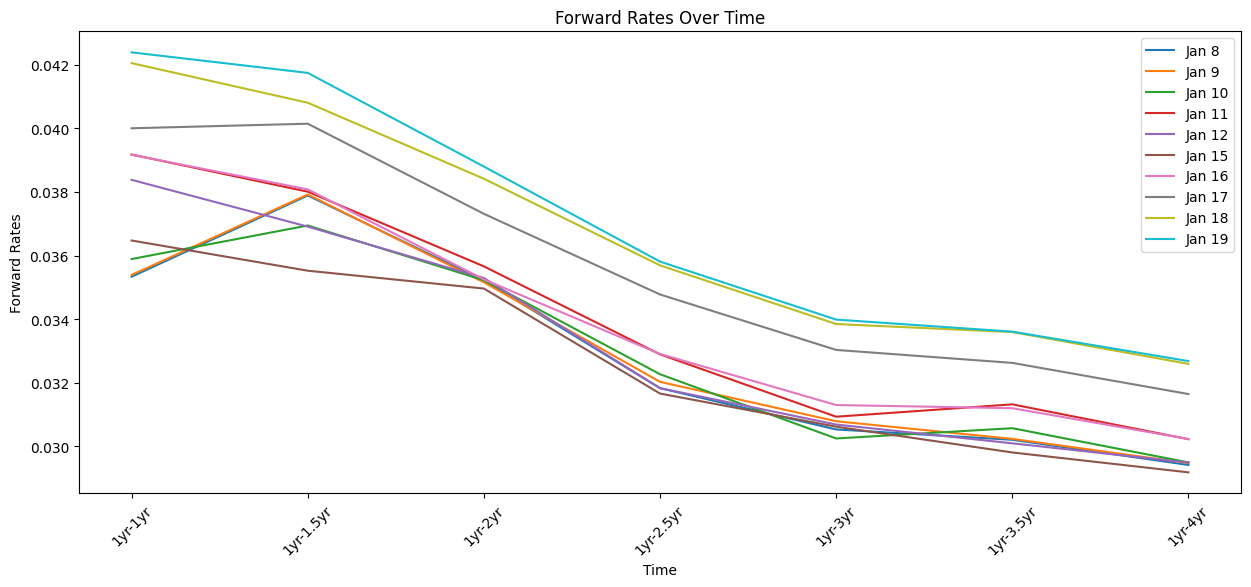

In [172]:

forward_columns = [col for col in df.columns if col.endswith('_forward')]

df_forward = df[forward_columns].copy()

dates = ["Jan 8", "Jan 9", "Jan 10", "Jan 11", "Jan 12", "Jan 15", "Jan 16", "Jan 17", "Jan 18", "Jan 19"]
forward_curve_X = ["1yr-1yr", "1yr-1.5yr", "1yr-2yr", "1yr-2.5yr", "1yr-3yr", "1yr-3.5yr", "1yr-4yr"]


plt.figure(figsize=(15, 6))

for date in dates:
    # Construct the column name and extract the relevant data
    column_name = f'{date}_forward'
    if column_name in df_forward.columns:
        forward_rates = df_forward[column_name][:7]
        plt.plot(forward_curve_X, forward_rates, label=date)

# Set plot title, labels, and legend
plt.title('Forward Rates Over Time')
plt.xlabel('Time')
plt.ylabel('Forward Rates')
plt.xticks(rotation=45)
plt.legend()

# Display the plot
plt.show()


Covariance Matrix for the Time Series of Daily Log-returns of Yield

In [173]:
rows = df_ytm.iloc[::2].head(5)
matrix1 = rows.values
yield1 = np.log(matrix1.T[1:]/matrix1.T[:-1]).T
cov = np.cov(yield1)
print(cov)

[[2.99358419e-04 1.31508523e-04 9.97404852e-05 5.87967673e-05
  3.23559312e-05]
 [1.31508523e-04 3.30331379e-04 2.51177737e-04 2.74666844e-04
  2.65482458e-04]
 [9.97404852e-05 2.51177737e-04 2.64533834e-04 2.90580051e-04
  2.67542021e-04]
 [5.87967673e-05 2.74666844e-04 2.90580051e-04 3.44480393e-04
  3.19011366e-04]
 [3.23559312e-05 2.65482458e-04 2.67542021e-04 3.19011366e-04
  3.01194294e-04]]


Eigenvalues of Covariance Matrix for the Time Series of Daily Log-returns of Yield

In [174]:
yield_eigenvalues,yield_eigenvectors = np.linalg.eig(cov)
print(yield_eigenvalues)


[1.17614557e-03 2.97079613e-04 5.96967327e-05 6.75258774e-06
 2.23811625e-07]


Eigenvectors of Covariance Matrix for the Time Series of Daily Log-returns of Yield

In [175]:
print(yield_eigenvectors)

[[-0.17936675 -0.93199586 -0.2340237   0.17122117  0.12299391]
 [-0.48918106 -0.14504136  0.84493854 -0.03453739 -0.15668735]
 [-0.46463305  0.00641867 -0.31851984 -0.82107144 -0.09198767]
 [-0.52381413  0.20649399 -0.35120436  0.49692559 -0.55919535]
 [-0.48812329  0.26012642 -0.0806993   0.21999347  0.79947508]]


Covariance Matrix for Forward Rates

In [176]:
matrix2 = df_forward.values[:-4, :]
forward1 = np.log(matrix2.T[1:]/matrix2.T[:-1]).T
cov1 = np.cov(forward1)
print(cov1)

[[0.00191248 0.00122239 0.00039376 0.00070016 0.0004725  0.00088636
  0.00075562]
 [0.00122239 0.00139621 0.00052402 0.0007945  0.0006413  0.00085072
  0.00075956]
 [0.00039376 0.00052402 0.00044492 0.00045148 0.00039637 0.00043016
  0.00041183]
 [0.00070016 0.0007945  0.00045148 0.0006576  0.0004617  0.00068892
  0.00057998]
 [0.0004725  0.0006413  0.00039637 0.0004617  0.00045918 0.00044315
  0.00043545]
 [0.00088636 0.00085072 0.00043016 0.00068892 0.00044315 0.00075808
  0.00061949]
 [0.00075562 0.00075956 0.00041183 0.00057998 0.00043545 0.00061949
  0.00053778]]


Eigenvalue of Covariance Matrix for Forward Rates

In [177]:
forward_eigenvalues,forward_eigenvectors = np.linalg.eig(cov1)
print(forward_eigenvalues)

[4.92845115e-03 7.92863163e-04 2.49214658e-04 1.52688539e-04
 4.04387121e-05 2.44804630e-06 1.42582496e-07]


Eigenvectors of Covariance Matrix for Forward Rates

In [181]:
print(forward_eigenvectors)

[[-0.53672109  0.77374553  0.17421366  0.26179112  0.01328755 -0.11772748
  -0.01808347]
 [-0.49766846 -0.0818509  -0.80313714 -0.22091996 -0.2250006   0.02864043
  -0.01860382]
 [-0.22593371 -0.38341902  0.20904877  0.56573812 -0.64865043  0.02418662
  -0.12980921]
 [-0.33450974 -0.30145334  0.27569949 -0.29920605  0.04218794 -0.74910234
   0.26222228]
 [-0.25052068 -0.33259383 -0.14124561  0.49011609  0.7120312  -0.0457797
  -0.2395254 ]
 [-0.36841176 -0.1396753   0.38900718 -0.48244536  0.04391371  0.35773798
  -0.57513354]
 [-0.32066482 -0.163114    0.18338985 -0.01042075  0.13324458  0.54176417
   0.72495857]]
